# Degree Preserving Edge Swaps

In [1]:
from graspologic.datasets import load_drosophila_right
from graspologic.models import EdgeSwapper
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import networkx as nx
from scipy.sparse import csr_array

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packag

/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/opt/hostedtoolcache/Python/3.8.16/x64/lib/python3.8/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/runner/work/graspologic/graspologic/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


`EdgeSwapper` is a class that performs degree preserving edge swaps on networks. The distributions of graphs with a fixed degree sequence are known as configuration models, and these have extensive application for analyzing network datasets. The current implementation works on simple graphs (unewighted, no loops) that are of type `np.ndarray` or `csr_array`.

Now let us run dpes on these graphs and ensure that they have the same degree sequence

To begin, we'll look at an example network, the _Drosophila melanogaster_ larva right mushroom body connectome from [Eichler et al. 2017](https://www.ncbi.nlm.nih.gov/pubmed/28796202). 

Note: here we make the network undirected and unweighted for compatibility with the current
implementation.

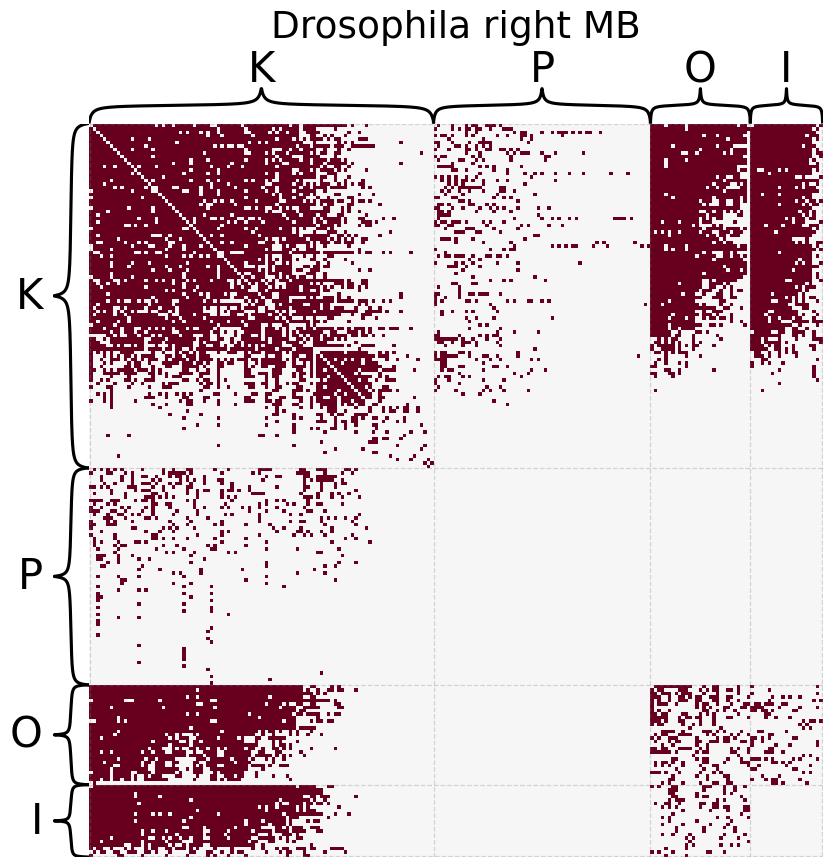

In [2]:
#load the data
adj, labels = load_drosophila_right(return_labels=True)
adj = symmetrize(adj)
adj = binarize(adj)
_ = heatmap(adj,
        inner_hier_labels=labels,
        title='Drosophila right MB',
        font_scale=1.5,
        sort_nodes=True, 
        cbar=False)


Now, we'll use `EdgeSwapper` to perform 10,000 random degree-preserving edge swaps - this
will dramatically change the structure of the network but keep the degree of each node
the same.  

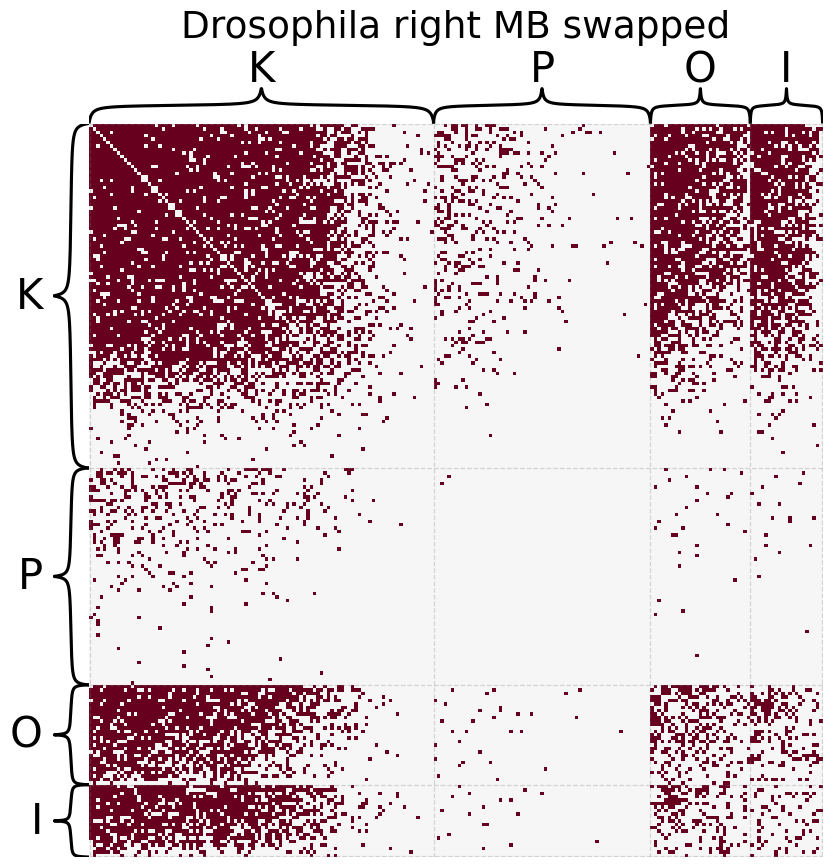

In [3]:
swapper = EdgeSwapper(adj, seed=8888)
swapped_adj, _ = swapper.swap_edges(n_swaps=10000)
_ = heatmap(swapped_adj,
        title='Drosophila right MB swapped',
        font_scale=1.5,
        sort_nodes=True, 
        inner_hier_labels=labels,
        cbar=False)

We can see how the structure of the network above has changed: for example, there are
now many edges among "I" (input) neurons when there were none before. 

We can verify that the degree of each node in the network has been preserved:

In [4]:
g = nx.from_numpy_array(adj)
swapped_g = nx.from_numpy_array(swapped_adj)
print(list(g.degree()) == list(swapped_g.degree()))

True


`EdgeSwapper` also works with `csr_array` adjacency representations. 

In [5]:
swapper = EdgeSwapper(csr_array(adj), seed=8888)
swapped_adj, _ = swapper.swap_edges(n_swaps=1000)
g = nx.from_numpy_array(adj)
swapped_g = nx.from_numpy_array(swapped_adj)
print(list(g.degree()) == list(swapped_g.degree()))

True


Often, degree-preserving edge swaps are used to sample a series of networks which resemble
the original network in degree, but are otherwise random. This distribution of networks
(sometimes called a configuration model) can be used to compare properties of the original
network to this null distribution in order to evaluate whether some property is more or
less prevalent in a given network than would be expected by chance. However, it is important
to know that in practice, it can be difficult to tell _how many_ edge swaps to perform
to find a new network which is independent from the one you started with. 